![](https://drive.google.com/uc?export=view&id=1-5X9OUkA-C2Ih1gOS9Jd7GmkTWUEpDg1)

Asignatura: Introducción a Data Science

Profesor: Juan Bekios Calfa

---

# Laboratorio 3: Deep learning (Perros y gatos)

Procedimiento:

1.   Cargar la base de datos ([https://www.kaggle.com/chetankv/dogs-cats-images?](https://www.kaggle.com/chetankv/dogs-cats-images?))
2.   Realizar las transformaciones



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Cargar las librerías

In [3]:
import torch
import torchvision
from torchvision import transforms, datasets

## 2. Cargar imágenes

Se cargan las imágenes utilizando la clase **ImageFolder**. La clase ImageForder etiqueta automáticamente las imágenes dada una ruta donde se encuentran los datos. Por ejemplo, si tengo el directorio raíz dataset/training_set. Debo dejar mis imágenes de cada clase en una carpeta diferente. Si tengo imágenes de gatos debo dejarlos en dataset/training_set/cats, si tengo imágenes de perros las debo dejar en dataset/training_set/dogs, etc.

In [9]:
data_transform = transforms.Compose([
        transforms.Resize((128,128)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
gatos_perros_dataset = datasets.ImageFolder(root='/content/drive/My Drive/D-UCN/Classes/TecnicasAvanzadasAprendizajeAutomatico/Laboratorios/Laboratorio05.2:DeepLearning/dataset/training_set',
                                           transform=data_transform)
print(gatos_perros_dataset)
dataset_loader = torch.utils.data.DataLoader(gatos_perros_dataset,
                                             batch_size=32, shuffle=False,
                                             num_workers=0)
print(dataset_loader)

Dataset ImageFolder
    Number of datapoints: 6000
    Root location: /content/drive/My Drive/D-UCN/Classes/TecnicasAvanzadasAprendizajeAutomatico/Laboratorios/Laboratorio05.2:DeepLearning/dataset/training_set
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


## 3. Visualizo las imágenes cargadas

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

def imshow(img):
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img, (1, 2, 0)))

# Obtener imagenes
data_iter = iter(dataset_loader)
images, labels = data_iter.next()

# Mostrar imagenes
imshow(torchvision.utils.make_grid(images))

## 4. Separando la base de datos

Para realizar el entrenamiento y pruebas se recomienda separar los datos en tres conjuntos:

* **Conjunto de entrenamiento:** El modelo aprende de los ejemplos de este conjunto de datos. Se ajusta un parámetro a un clasificador.
* **Conjunto de validación:** Los ejemplos en el conjunto de datos de validación se utilizan para ajustar los hiperparámetros, como la tasa de aprendizaje y las épocas. El objetivo de crear un conjunto de validación es evitar un sobreajuste grande del modelo. Es un punto de control para saber si el modelo se ajusta bien con el conjunto de datos de entrenamiento.
* **Conjunto de pruebas:** Este conjunto de datos prueba la evolución final del modelo, midiendo qué tan bien aprendió y predijo el resultado deseado. Contiene datos invisibles de la vida real. Es un conjunto diferente al de entrenamiento y validación.

Imagen: [https://i.imgur.com/DV80uhS.png](https://i.imgur.com/DV80uhS.png)

In [ ]:
# Transformaciones sobre las imágenes
data_transform = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

# Carga de las imágenes
gatos_perros_train = datasets.ImageFolder(root='/content/drive/My Drive/D-UCN/Classes/TecnicasAvanzadasAprendizajeAutomatico/Laboratorios/Laboratorio05.2:DeepLearning/dataset/training_set',
                                           transform=data_transform)
gatos_perros_valid = datasets.ImageFolder(root='/content/drive/My Drive/D-UCN/Classes/TecnicasAvanzadasAprendizajeAutomatico/Laboratorios/Laboratorio05.2:DeepLearning/dataset/valid_set',
                                           transform=data_transform)
gatos_perros_test = datasets.ImageFolder(root='/content/drive/My Drive/D-UCN/Classes/TecnicasAvanzadasAprendizajeAutomatico/Laboratorios/Laboratorio05.2:DeepLearning/dataset/test_set',
                                           transform=data_transform)

# Conjunto de entrenamiento
train_loader = torch.utils.data.DataLoader(gatos_perros_train,
                                             batch_size=32, shuffle=True,
                                             num_workers=2)

# Conjunto de validación
valid_loader = torch.utils.data.DataLoader(gatos_perros_valid,
                                             batch_size=32, shuffle=False,
                                             num_workers=2)

# Conjunto de pruebas
test_loader = torch.utils.data.DataLoader(gatos_perros_test,
                                             batch_size=32, shuffle=False,
                                             num_workers=2)

### Revisamos las imagenes de las nuevas cargas



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


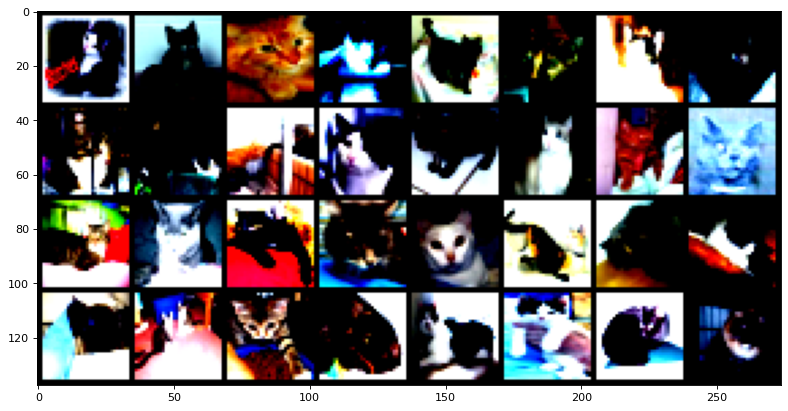

In [ ]:
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

# Obtener imagenes
data_iter = iter(valid_loader)
images, labels = data_iter.next()

# Mostrar imagenes
imshow(torchvision.utils.make_grid(images))

## 5. El modelo

Construimos un modelo con dos capas convolucionales, un dropout y dos capas completamente conectadas para la clasificación.

* Imagen red: [https://i.imgur.com/wiP9IwZ.png](https://i.imgur.com/wiP9IwZ.png)
* Imagen Conv: https://i.imgur.com/E9GGJMJ.gif
* Imagen Pool: https://i.imgur.com/kSwID7J.png

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(720, 1024)
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

### Creamos el modelo

In [ ]:
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=720, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)


## 6. Optimización

Seleccionamos cualquier algoritmo optimizador disponible en el paquete `torch.optim`. En general, los optimizadores son moficaciones del descenso del gradiente. Cambiando los parámetros del modelo, como los pesos, y añadiendo sesgo, el modelo puede ser optimizado. La **tasa de aprendizaje** decidirá cuán grandes deben ser los pasos para cambiar los parámetros.

* Calcular lo que un pequeño cambio en cada peso haría a la función de pérdida (seleccionando la dirección para alcanzar los mínimos).
* Ajustar cada peso en función de su gradiente (es decir, dar un pequeño paso en la dirección determinada).
* Continúe haciendo los pasos 1 y 2 hasta que la función de pérdida sea lo más baja posible.

Aquí, la estimación del momento adaptativo (*adaptive moment estimation* - Adam) se utiliza como un optimizador. Es una mezcla de **RMSprop** y **descenso de gradiente estocástico**.

### Configuración de Hyperparámetros

In [ ]:
# Hyper parameters
num_epochs = 35
num_classes = 2
batch_size = 25
learning_rate = 0.1

### Configuración del dispositivo

In [ ]:
# CPU or GPU

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

### Optimizador

In [ ]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

## 7. Entrenamiento

In [ ]:
%%timeit
# keeping-track-of-losses 
train_losses = []
valid_losses = []

for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    model.eval()
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

## 8. Pruebas


In [ ]:
# test-the-model
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

# Save 
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model: 50.0 %


9. Graficamos los resultados

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

NameError: ignored